In [2]:
from datasets import load_dataset
dataset = load_dataset("mnist")

README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

## Prepare Dataset
Load and Examine Dataset

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [4]:
sample = dataset['train']['image'][0]
sample_label = dataset['train']['label'][0]

In [5]:
sample, sample_label

(<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>, 5)

5


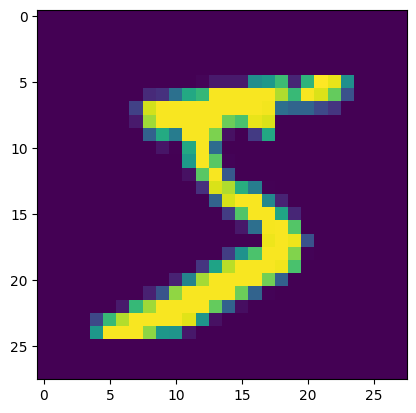

In [6]:
import matplotlib.pyplot as plt
print(sample_label)
plt.imshow(sample)

## Transform Dataset for Training

In [7]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(2), ## send the size becomes 32x32
    ## https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html
    transforms.Normalize([0.5],[0.5]) ## normalize the range into -1 to 1
])

Check the shape of data after transformation

In [8]:
import torch
batch_size = 512

def transform(examples):
    ## https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert
    ## convert PIL Image to L mode (GrayScale)
    images = [preprocess(image.convert("L")) for image in examples["image"]]

    return {"images":images, "labels":examples["label"]}

train_dataset = dataset['train'].with_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle=True
)

In [9]:
batch = next(iter(train_dataloader))
print('Shape:', batch['images'].shape,
      '\nBounds:', batch['images'].min().item(), 'to', batch['images'].max().item())

Shape: torch.Size([512, 1, 32, 32]) 
Bounds: -1.0 to 1.0


## Build the Model

In [10]:
from diffusers import UNet2DModel

unet = UNet2DModel(
    in_channels=1,
    out_channels=1,
    sample_size=32,
    block_out_channels=(32,64,128,256),
    norm_num_groups=8,
    num_class_embeds=10
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Test the inference and the output shape

In [11]:
noised_x = torch.randn((1, 1, 32, 32))
with torch.no_grad():
    out = unet(noised_x, timestep=7, class_labels=torch.tensor([2])).sample

out.shape

torch.Size([1, 1, 32, 32])

## Training

In [12]:
import torch.nn.functional as F
from tqdm import tqdm

from diffusers import DDPMScheduler

def train(num_epochs=30, lr=1e-4, device="cuda"):
    scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02)
    optimizer = torch.optim.AdamW(unet.parameters(), lr=lr) # The optimizer
    losses = [] # somewhere to store the loss values for later plotting
    unet.to(device)

    # Train the model (this takes a while!)
    for epoch in range(num_epochs):
        for step, batch in tqdm(enumerate(train_dataloader)):

            # Load the input images
            clean_images = batch["images"].to(device)
            class_labels = batch["labels"].to(device)

            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0,
                scheduler.config.num_train_timesteps,
                (clean_images.shape[0],),
                device=clean_images.device,
            ).long()

            # Add noise to the clean images according timestep
            noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

            # Get the model prediction for the noise
            noise_pred = unet(noisy_images, timesteps, class_labels=class_labels, return_dict=False)[0]

            # Compare the prediction with the actual noise:
            loss = F.mse_loss(noise_pred, noise)
            losses.append(loss)
            # Store the loss for later plotting
            # Update the model parameters with the optimizer based on this loss
            loss.backward(loss)
            optimizer.step()
            optimizer.zero_grad()
        print(f"Epoch {epoch}: loss={losses[-1]}")
    return losses

In [13]:
losses = train()

118it [01:52,  1.04it/s]


Epoch 0: loss=0.1325972080230713


118it [01:51,  1.05it/s]


Epoch 1: loss=0.09378191083669662


118it [01:51,  1.05it/s]


Epoch 2: loss=0.07209588587284088


118it [01:52,  1.05it/s]


Epoch 3: loss=0.05439606308937073


118it [01:52,  1.05it/s]


Epoch 4: loss=0.06066245958209038


118it [01:51,  1.05it/s]


Epoch 5: loss=0.04885260760784149


118it [01:51,  1.05it/s]


Epoch 6: loss=0.0416167750954628


118it [01:51,  1.06it/s]


Epoch 7: loss=0.047721683979034424


118it [01:51,  1.06it/s]


Epoch 8: loss=0.033292364329099655


118it [01:51,  1.06it/s]


Epoch 9: loss=0.045422039926052094


118it [01:51,  1.06it/s]


Epoch 10: loss=0.03524807095527649


118it [01:51,  1.06it/s]


Epoch 11: loss=0.03403984382748604


118it [01:51,  1.06it/s]


Epoch 12: loss=0.030451234430074692


118it [01:51,  1.06it/s]


Epoch 13: loss=0.027445441111922264


118it [01:51,  1.05it/s]


Epoch 14: loss=0.0382767878472805


118it [01:52,  1.05it/s]


Epoch 15: loss=0.0306419488042593


118it [01:52,  1.05it/s]


Epoch 16: loss=0.02459515444934368


118it [01:52,  1.05it/s]


Epoch 17: loss=0.023863770067691803


118it [01:51,  1.06it/s]


Epoch 18: loss=0.022374501451849937


118it [01:51,  1.05it/s]


Epoch 19: loss=0.02972579002380371


118it [01:52,  1.05it/s]


Epoch 20: loss=0.022356227040290833


118it [01:52,  1.05it/s]


Epoch 21: loss=0.022434819489717484


118it [01:52,  1.05it/s]


Epoch 22: loss=0.029154803603887558


118it [01:52,  1.05it/s]


Epoch 23: loss=0.024483010172843933


118it [01:52,  1.05it/s]


Epoch 24: loss=0.024230940267443657


118it [01:52,  1.05it/s]


Epoch 25: loss=0.027546880766749382


118it [01:52,  1.05it/s]


Epoch 26: loss=0.02587004564702511


118it [01:51,  1.06it/s]


Epoch 27: loss=0.020630789920687675


118it [01:51,  1.06it/s]


Epoch 28: loss=0.01809917762875557


118it [01:51,  1.05it/s]

Epoch 29: loss=0.015931110829114914


In [20]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
token = user_secrets.get_secret("HF_TOKEN")

unet.push_to_hub("unet-mnist-32", variant="fp16", token=token)

README.md:   0%|          | 0.00/2.70k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/gnokit/unet-mnist-32/commit/00db4b2b30541a638ad46174f46e493b4112a3b7', commit_message='Upload model', commit_description='', oid='00db4b2b30541a638ad46174f46e493b4112a3b7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gnokit/unet-mnist-32', endpoint='https://huggingface.co', repo_type='model', repo_id='gnokit/unet-mnist-32'), pr_revision=None, pr_num=None)

In [23]:
model = UNet2DModel.from_pretrained("gnokit/unet-mnist-32", use_safetensors=True, variant="fp16").to("cuda")

In [26]:
# Method 1: Count total parameters
total_params = sum(p.numel() for p in model.parameters())

# Method 2: Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Optional: More detailed parameter breakdown
print("\nParameter groups:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,} parameters")

Total parameters: 15,892,033
Trainable parameters: 15,892,033

Parameter groups:
conv_in.weight: 288 parameters
conv_in.bias: 32 parameters
time_embedding.linear_1.weight: 4,096 parameters
time_embedding.linear_1.bias: 128 parameters
time_embedding.linear_2.weight: 16,384 parameters
time_embedding.linear_2.bias: 128 parameters
class_embedding.weight: 1,280 parameters
down_blocks.0.resnets.0.norm1.weight: 32 parameters
down_blocks.0.resnets.0.norm1.bias: 32 parameters
down_blocks.0.resnets.0.conv1.weight: 9,216 parameters
down_blocks.0.resnets.0.conv1.bias: 32 parameters
down_blocks.0.resnets.0.time_emb_proj.weight: 4,096 parameters
down_blocks.0.resnets.0.time_emb_proj.bias: 32 parameters
down_blocks.0.resnets.0.norm2.weight: 32 parameters
down_blocks.0.resnets.0.norm2.bias: 32 parameters
down_blocks.0.resnets.0.conv2.weight: 9,216 parameters
down_blocks.0.resnets.0.conv2.bias: 32 parameters
down_blocks.0.resnets.1.norm1.weight: 32 parameters
down_blocks.0.resnets.1.norm1.bias: 32 para